### Feature Selection

The first example uses L1 regularization to train a model with sparse weight parameters to prevent overfitting

The second example uses a sequential feature selection algorithm to select input features

In [1]:
import pandas as pd

df_wine = pd.read_csv(
    'https://archive.ics.uci.edu/ml/'
    'machine-learning-databases/wine/wine.data',
    header=None
)

In [2]:
df_wine.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
df_wine.columns = [
    'Class label', 
    'Alcohol',
    'Malic acid',
    'Ash',
    'Alcalinity of ash',
    'Magnesium',
    'Total phenols',
    'Flavanoids',
    'Nonflavanoid phenols',
    'Proanthocyanins',
    'Color intensity', 
    'Hue',
    'OD280/OD315 of diluted wines',
    'Proline'
]

In [4]:
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [5]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
print(X.shape)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y) 

(178, 13)


In [6]:
X_train.shape, y_train.shape

((124, 13), (124,))

In [7]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [8]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    multi_class='ovr'
)

model.fit(X_train_std, y_train)

print('Training accuracy: ', model.score(X_train_std, y_train))
print('Test accuracy: ', model.score(X_test_std, y_test))

Training accuracy:  1.0
Test accuracy:  0.9814814814814815


In [9]:
# To get bias parameters
print(model.intercept_)

[-1.11947944 -1.13592679 -2.22640627]


In [10]:
# to get weight parameters
print(model.coef_)

[[ 1.41253548  0.          0.27956635 -1.36246686  0.          0.
   1.26969033  0.          0.          0.          0.          0.71295972
   2.21998197]
 [-1.6891562  -0.37306612 -0.8251099   0.68111379 -0.11970777  0.
   0.39891608  0.01242679  0.24764666 -1.42756332  1.05827978  0.
  -2.22889151]
 [ 0.          0.23305343  0.50679818  0.          0.16151665  0.
  -2.48545797 -0.11868289  0.          1.64944785 -0.88828193 -0.37847663
   0.        ]]


Another way to reduce complexity of model is dimensionality reduction via feature selection which is useful for unregularized models

2 types of dimensionality reduction:
* feature selection
* feature extraction

Using feature selection, we select a subset of original features

Using feature extraction, we derive information from feature set to build a new feature subspace i.e. PCA

Sequential feature selection algos are a family of greedy search algos used to reduce an initial d-dimensional feature space to a k-dimensional feature subspace where k < d

Aim of feature selection algos is to automatically select a subset of features most relevant to problem, to improve computational efficiency, or to reduce generalization error of model by removing irrelevant features or noise

#### On greedy search algorithms

Greedy algorithms make locally optimal choices at each stage of a combinatorial search problem and generally yield a suboptimal solution to the problem, in contrast to exhaustive search algorithms, which evaluate all possible combinations and are guaranteed to find the optimal solution. However, in practice, an exhaustive search is often computationally not feasible, whereas greedy algorithms allow for a less complex, computationally more efficient solution.



SBS - Sequential backward selection algo

SBS sequentially removes features from full feature subset until new feature subspace contains desired num of features

Define a criterion function, J, that we want to minimize

Critertion calculated by criterion function can be difference in performance of classifier before and after removal of a particular feature

AT each stage, we remove the feature that causes the least performance loss after removal

In [25]:
from itertools import combinations
from sklearn.base import clone
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class SBS:
    def __init__(self, estimator, k_features, scoring=accuracy_score, test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(
          X, y, test_size=self.test_size, random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]
        
        while dim > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])
            
        self.k_score = self.scores_[-1]
        
        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score


In [26]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

[13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]


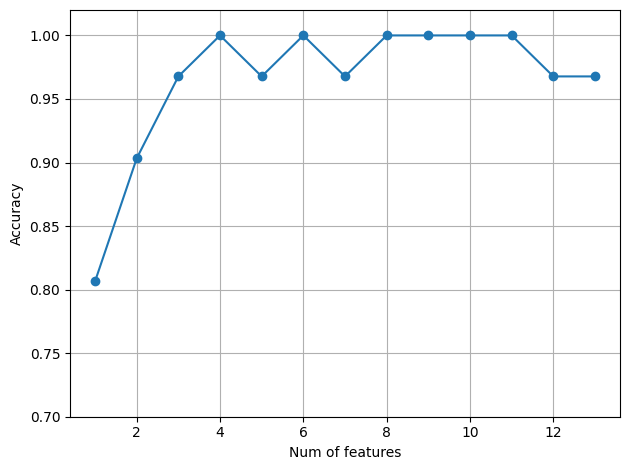

In [27]:
k_feat = [len(k) for k in sbs.subsets_]
print(k_feat)

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Num of features')
plt.grid()
plt.tight_layout()
plt.show()

In [28]:
k3 = list(sbs.subsets_[10])
print(df_wine.columns[1:][k3])

Index(['Alcohol', 'Total phenols', 'Color intensity'], dtype='object')


In [30]:
knn.fit(X_train_std, y_train)
print('Train accuracy: ', knn.score(X_train_std, y_train))
print('Test accuracy: ', knn.score(X_test_std, y_test))

Train accuracy:  0.9596774193548387
Test accuracy:  0.9259259259259259


In [49]:
knn.fit(X_train_std[:, k3], y_train)
print('Train acc: ', knn.score(X_train_std[:, k3], y_train))
print('Test acc: ', knn.score(X_test_std[:, k3], y_test))

Train acc:  0.9354838709677419
Test acc:  0.8888888888888888


### Accessing feature importance with random forests


Using random forest which is an ensemble of decision trees

measure feature importance as averaged impurity decrease computed from all decision trees, w/o any assumptions on whether data is linearly separable or not

the random forest implementation in scikit-learn already collects the features_importances_ attribute after fitting a random forest classifier

the feature importance values all sum up to 1.0


scikit-learn also provides SelectFromModel objecte that selects features based on user-specified threshold after model fitting e.g. set threshold below to 0.1 to reduce dataset to 5 most important features

Index(['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium',
       'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
       'Proanthocyanins', 'Color intensity', 'Hue',
       'OD280/OD315 of diluted wines', 'Proline'],
      dtype='object')
(124, 13)
1 Proline 0.17992693779934774
2 Color intensity 0.1531577060918445
3 Flavanoids 0.14612286806893526
4 Alcohol 0.13822434128388703
5 OD280/OD315 of diluted wines 0.11481799554990077
6 Hue 0.07752497212441119
7 Total phenols 0.058235657900474025
8 Malic acid 0.030855737083571706
9 Alcalinity of ash 0.02999980079201223
10 Proanthocyanins 0.025713395711502687
11 Magnesium 0.02513494158344364
12 Nonflavanoid phenols 0.011547594195815256
13 Ash 0.00873805181485404


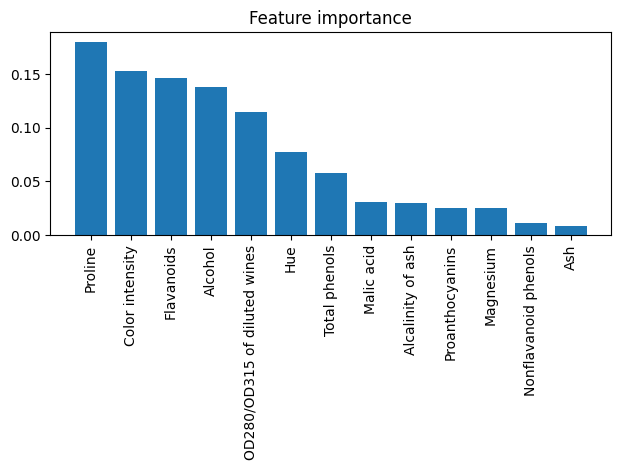

In [44]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]
print(feat_labels)

forest = RandomForestClassifier(
    n_estimators=500,
    random_state=1
)

forest.fit(X_train, y_train)

print(X_train.shape)

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print(f+1, feat_labels[indices[f]], importances[indices[f]])

plt.title('Feature importance')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [50]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(
    forest, threshold=0.1, prefit=True)

X_selected = sfm.transform(X_train)
print(X_selected.shape)
print('Num of features that meet threshold: ', X_selected.shape[1])

for f in range(X_selected.shape[1]):
    print(f+1, feat_labels[indices[f]], importances[indices[f]])

(124, 5)
Num of features that meet threshold:  5
1 Proline 0.17992693779934774
2 Color intensity 0.1531577060918445
3 Flavanoids 0.14612286806893526
4 Alcohol 0.13822434128388703
5 OD280/OD315 of diluted wines 0.11481799554990077
